In [283]:
%load_ext autoreload
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
import torch.functional as F
import torchvision
import tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader
from collections import defaultdict

from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from utils import *
from train_utils import *
from mlp import MLP
from train_utils import get_grad_params

from IPython.core.debugger import set_trace

%autoreload 2

device = torch.device('cuda:0')
N_CPU = cpu_count()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_phase_portrait(derivative_func, x_range, y_range, num_points=200, t=0):
#     x_values = np.linspace(x_range[0], x_range[1], num_points)
#     y_values = np.linspace(y_range[0], y_range[1], num_points)

#     X, Y = np.meshgrid(x_values, y_values)
#     U, V = np.zeros_like(X), np.zeros_like(Y)

#     for i in range(num_points):
#         for j in range(num_points):
#             dx_dt, dy_dt = derivative_func(t, X[i, j], Y[i, j])
#             U[i, j] = dx_dt
#             V[i, j] = dy_dt

#     plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=10, color='b')

#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('2D Phase Portrait')
#     plt.grid(True)
#     plt.axhline(0, color='black', lw=0.5)
#     plt.axvline(0, color='black', lw=0.5)
#     plt.xlim(x_range[0], x_range[1])
#     plt.ylim(y_range[0], y_range[1])
#     plt.gca().set_aspect('equal', adjustable='box')


# # Replace the following function with your actual derivative function
# def derivative_function(t, x, y):
#     # Example: Lotka-Volterra equations (predator-prey model)
# #     alpha = 1.2
# #     beta = 0.4
# #     delta = 0.6
# #     gamma = 0.8

# #     dx_dt = alpha * x - beta * x * y
# #     dy_dt = delta * x * y - gamma * y

#     dx_dt = x + y - (x**2)
#     dy_dt = (x**2)  - y

#     return dx_dt, dy_dt

# # Define the range of x and y values for plotting the phase portrait
# x_range = (-.1, .1)
# y_range = (-.1, .1)

# # Call the plot_phase_portrait function with the derivative function
# plot_phase_portrait(derivative_function, x_range, y_range, num_points=20)

# plt.arrow(0,0,2,0, color='red')
# plt.arrow(0,0,1,-2, color='green')


# plt.show()

In [11]:
mnist_train = torchvision.datasets.MNIST('./data', download=True, train=True,
                                         transform=torchvision.transforms.ToTensor())

mnist_test = torchvision.datasets.MNIST('./data', download=True, train=False,
                                       transform=torchvision.transforms.ToTensor())


d = 28**2
n_classes = 10

# baseline random embedding
inpt_test = mnist_test.data.view(-1,d).to(device).type(torch.float32) / 255.
target_test = mnist_test.targets.to(device)
y_test = to_numpy(target_test)

inpt_train = mnist_train.data.view(-1,d).to(device).type(torch.float32) / 255. 
target_train = mnist_train.targets.to(device)
y_train = to_numpy(target_train)

In [12]:
# plt.hist(to_numpy(inpt_train).flatten(), bins=100, alpha=0.6)
# plt.hist(to_numpy(inpt_test).flatten(), bins=100, alpha=0.6)
# plt.yscale('log')
# plt.show()

In [284]:
X_train = to_numpy(inpt_train)
X_train -= X_train.mean(0, keepdims=True) 
pca = PCA()
pca.fit(X_train)

PCA()

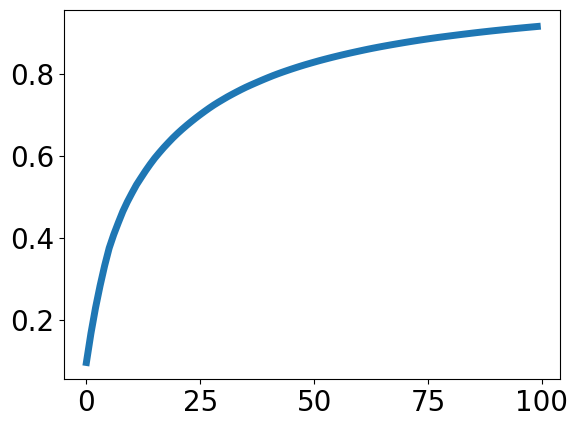

In [286]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100])

In [339]:
mlp_parameters = {
                'input_dim':d,
                'hidden_dim':20,
                'n_classes':n_classes,
                'W_requires_grad':True,
                'b_requires_grad':False,
                'activation':nn.Sigmoid(),
                'corruption':False,
                'y_H_max':1,
                'alpha':0.8,
                'delta_mult':1,
                'layers_number':3,
                'add_bn':True, # idk how it affects 
                'device':device
                }

model = MLP(**mlp_parameters).to(device)
ce_loss = nn.CrossEntropyLoss()

for n,p in model.named_parameters():
    print(n,p.requires_grad)

W_out True
W_s.0 True
W_s.1 True
W_s.2 True
b_s.0 False
b_s.1 False
b_s.2 False


In [340]:
def make_ls_solution(X,y,bias=False, alpha=1, onehot=True):
    '''
    X - tensor [N,d]
    y - tensor 
    '''
    y_oh = nn.functional.one_hot(y, num_classes=10).type(X.dtype)
    if not onehot:
        y_oh[y_oh == 0] = -1
    if bias:
        X_ = torch.cat([X, torch.ones_like(X[:,:1], 
                                           device=X.device, 
                                           dtype=X.dtype)], dim=-1)
    else:
        X_ = X.clone()
        
    S = X_.T@X_
    S += torch.eye(S.shape[0], device=X.device, dtype=X.dtype)*alpha # for stability
    W_ls = torch.inverse(S)@X_.T@y_oh
    
    y = X_ @ W_ls
    
    return W_ls, y 

In [341]:
H, output = model(inpt_test)
W_out_ls, output = make_ls_solution(H[-1][-1].T, target_test, bias=True)
target_pred = output.argmax(1)
acc_random = accuracy_score(to_numpy(target_test), to_numpy(target_pred))
print('Acc random', acc_random)

Acc random 0.4937


In [342]:
H_np = to_numpy(H[-1][-1].T)

In [343]:
# # def knn_acc(H_np)
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(H_np, y_test)
# accuracy_score(knn.predict(H_np), y_test)

In [344]:
inpt_test.shape

torch.Size([10000, 784])

In [345]:
W_out_ls, output = make_ls_solution(inpt_test, target_test, bias=True)
target_pred = output.argmax(1)
acc_orig = accuracy_score(to_numpy(target_test), to_numpy(target_pred))
# del W_out_ls, output, target_pred

print('Acc orig', acc_orig)

Acc orig 0.8877


In [346]:
epochs = 20

vis_freq = 10
save_freq = 10

batch_size = 200
lr = 5e-4

model = MLP(**mlp_parameters).to(device)

backprop_train = model.W_requires_grad
CONTEXT = torch.enable_grad if backprop_train else torch.no_grad
    
loss_name = 'Cross-Entropy'
metric_name = 'Accuracy'

loss_function = ce_loss
metric_function = accuracy

SAVE = False
SAVE_ACTIVATIONS = True
CALCULATE_METRIC = False

mnist_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

layers_num_iter = [1]
    
metrics = {'train':defaultdict(list),
           'val':defaultdict(list)}

if backprop_train:
    optimizer = torch.optim.Adam(get_grad_params(model.parameters()), lr=lr, weight_decay=1e-3)

if SAVE:
    EXP_COMMENT = 'sigmoid'
    
    hd = mlp_parameters['hidden_dim']
    nl = mlp_parameters['layers_number']
    bn = mlp_parameters['add_bn']
    corruption = mlp_parameters['corruption']
    y_H_max = mlp_parameters['y_H_max']
    alpha = mlp_parameters['alpha']
    
    backprop_train = mlp_parameters['W_requires_grad']

    EXP_NAME =  ('BP' if backprop_train else 'NoBP') +\
                (f'_hd{hd}') +\
                (f'_nl{nl}') +\
                (f'_bn{bn}') +\
                (f'corrupt{corruption}') +\
                (f'y_H_max{y_H_max}') +\
                (f'alpha{alpha}') +\
                (f'_lr{lr}') +\
                (f'_ep{epochs}') +\
                (f'_bs{batch_size}')

    EXP_NAME += EXP_COMMENT

    EXP_DIR = f'./checkpoints/{EXP_NAME}'

    os.makedirs(EXP_DIR, exist_ok=True)

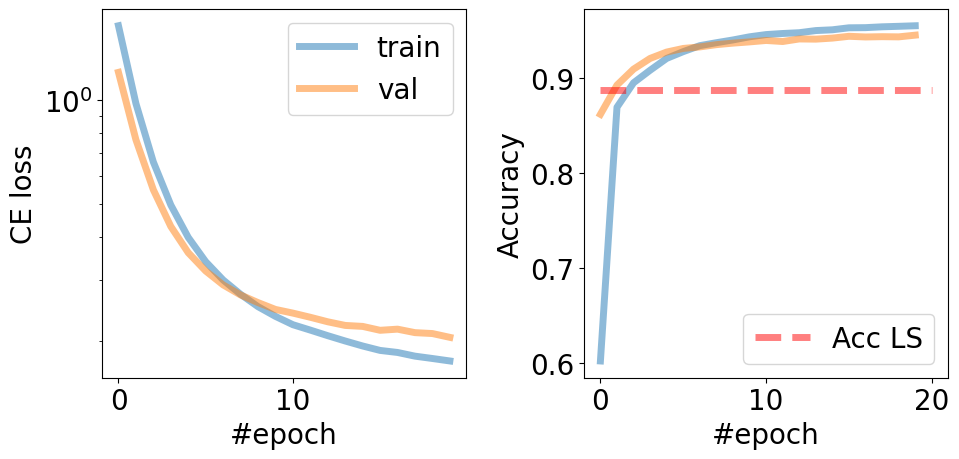

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]


In [347]:
# for layers_num in layers_num_iter:

#     # creating model
#     mlp_parameters['layers_number'] = layers_num
#     model = MLP(**mlp_parameters).to(device)


# train
model.corruption = False
for epoch in tqdm.trange(1,epochs+1):

    #########
    # TRAIN #
    #########
    model.train()

    # initial values
    loss_history = []
    metric_history = []

    n_train = len(mnist_train_dataloader)

    for batch, target_batch in mnist_train_dataloader:

        inpt = batch.view(-1, d).to(device)
        target_batch = target_batch.to(device)

        with CONTEXT():
            _, output = model(inpt) # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
        
        loss = loss_function(output.T, target_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        target_pred = output.argmax(0)
        metric = metric_function(target_batch, target_pred)
        
        loss_history.append(loss.item())
        metric_history.append(metric)

    ##### END OF EPOCH #####
    
    metrics['train'][f'{loss_name}'].append(np.mean(loss_history))
    metrics['train'][f'{metric_name}'].append(np.mean(metric_history))

    ##############
    # VALIDATION #
    ##############
    model.eval()
    with torch.no_grad():
        # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
        _, output = model(inpt_test) 
    
    loss = loss_function(output.T, target_test)
    target_pred = output.argmax(0)
    metric = metric_function(target_test, target_pred)

    metrics['val'][f'{loss_name}'].append(loss.item())
    metrics['val'][f'{metric_name}'].append(metric)

    # visualize
    if epoch % vis_freq == 0:

        clear_output()

        plt.rcParams['font.size'] = 20
        plt.rcParams['lines.linewidth'] = 5

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
        
        epoch_ = len(metrics['train'][f'{loss_name}'])

        axes[0].plot(metrics['train'][f'{loss_name}'], label='train', alpha=0.5)
        axes[0].plot(metrics['val'][f'{loss_name}'], label='val', alpha=0.5)
        axes[0].set_xlabel('#epoch')
        axes[0].set_ylabel('CE loss')
        axes[0].set_yscale('log')
        axes[0].legend()

        axes[1].plot(metrics['train'][f'{metric_name}'], alpha=0.5)
        axes[1].plot(metrics['val'][f'{metric_name}'], alpha=0.5)
        
        axes[1].hlines(acc_orig, 0, epoch_, 
                       alpha=0.5, color='red', 
                       linestyle='--', label='Acc LS')
        
        axes[1].legend()

        axes[1].set_xlabel('#epoch')
        axes[1].set_ylabel('Accuracy')


        plt.tight_layout()
        plt.show()

    if SAVE and (epoch % save_freq == 0):

        if SAVE_ACTIVATIONS:
            activations = []
            for l in layers_activations:
                activations.append(l[-1].detach().cpu())
            torch.save(activations, os.path.join(EXP_DIR, f'activations_{epoch}'))

        dW_train = np.stack(dW_hist['train'])
        metrics_dict = {}
        metrics_dict['ce_loss'] = loss_hist
        metrics_dict['acc'] = acc_hist

        weights_and_history = {'weights':model.state_dict(),
                               'metrics':metrics_dict}

        torch.save(weights_and_history, os.path.join(EXP_DIR, f'weights_and_history_{epoch}'))

In [348]:
model.y_mean_s[i][0].shape

(20,)

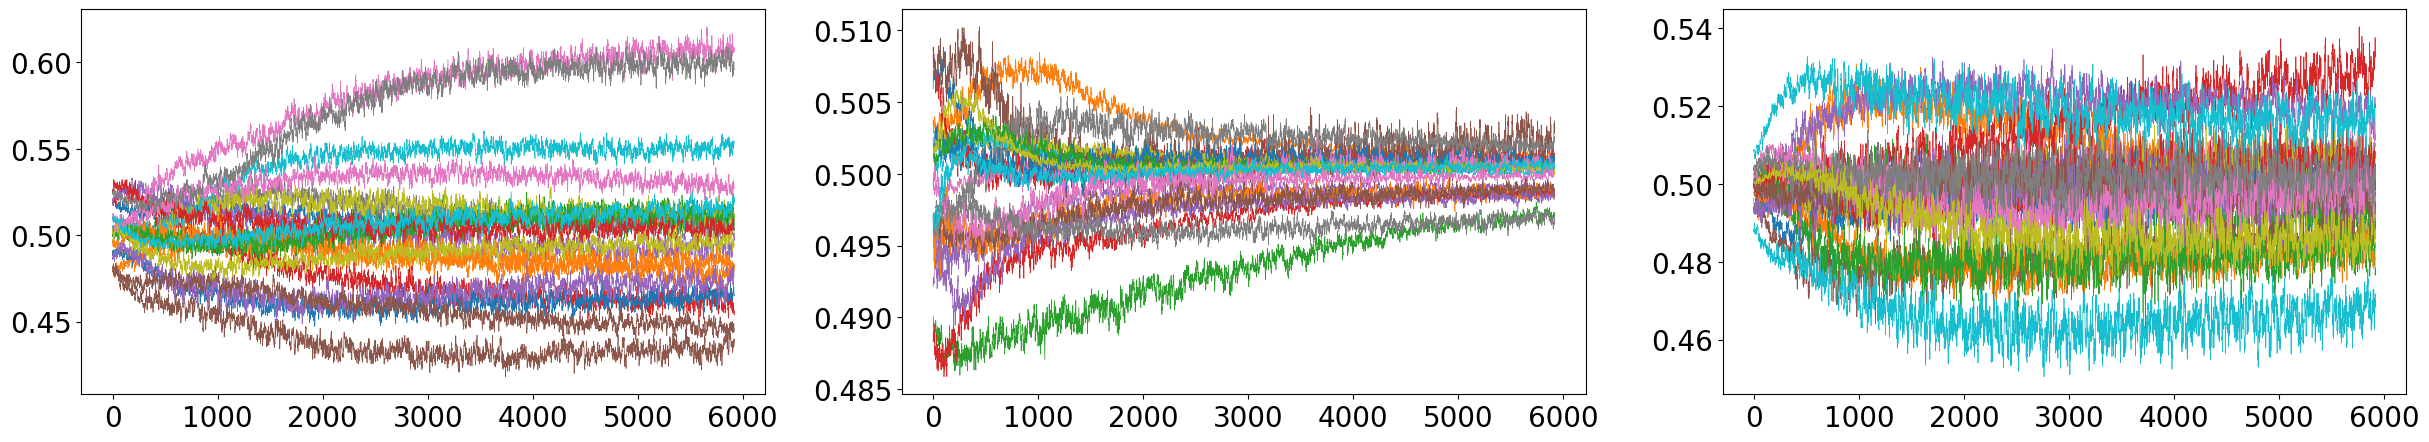

In [358]:
onset_time = 100
nl = mlp_parameters['layers_number']
fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(model.y_mean_s[i], axis=0)
    ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    delta_mean_i = np.stack(model.delta_mean_s[i], axis=0)
    ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

In [698]:
max_stimuli_repeat = 500

model.corruption = True
model.delta_mult = 1.

# zero stimuli presentaton
for i in range(max_stimuli):
    with torch.no_grad():
        layers, output = model(torch.zeros(1,d, device=device))
        target_pred = output.argmax()

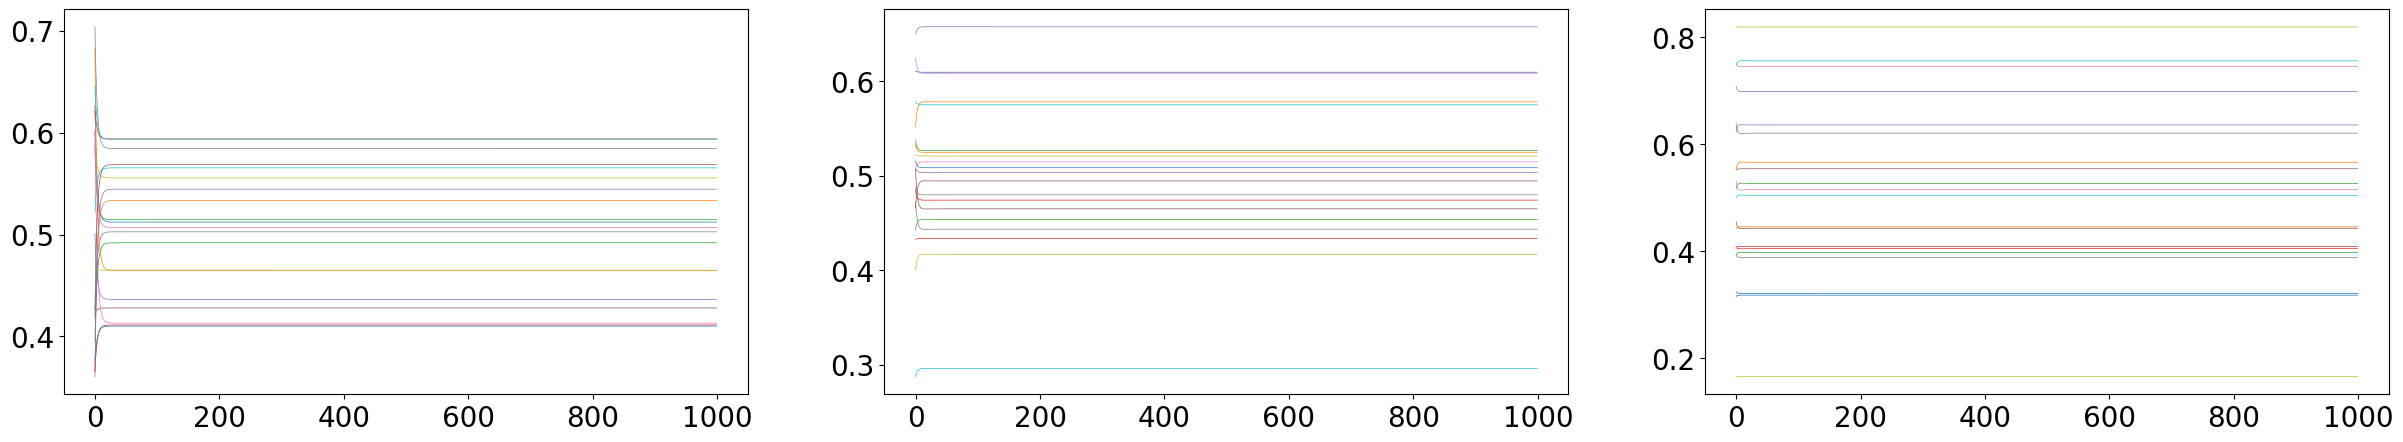

In [699]:
onset_time = 100
nl = mlp_parameters['layers_number']
fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(model.y_mean_s[i], axis=0)
    ax.plot(y_mean_i[-1000:,:], linewidth=0.5)
plt.show()

In [708]:
# converges to the theoretical firing rate
# np.abs(np.stack(model.y_mean_s[1], axis=0)[-1:] - to_numpy((model.y_H[1] + 2)/5.)).max()

layer_i = 1

I = to_numpy(layers[layer_i][1].squeeze(-1))
y_H_i = to_numpy(model.y_H[layer_i]) 
y_mean = model.y_mean_s[layer_i][-1] # last value

print(np.abs(y_mean - (I + y_H_i + 2)/5.).max())

print(np.abs(y_mean - (I + y_H_i + 2)/5.).max())

0.010088563
0.010088563


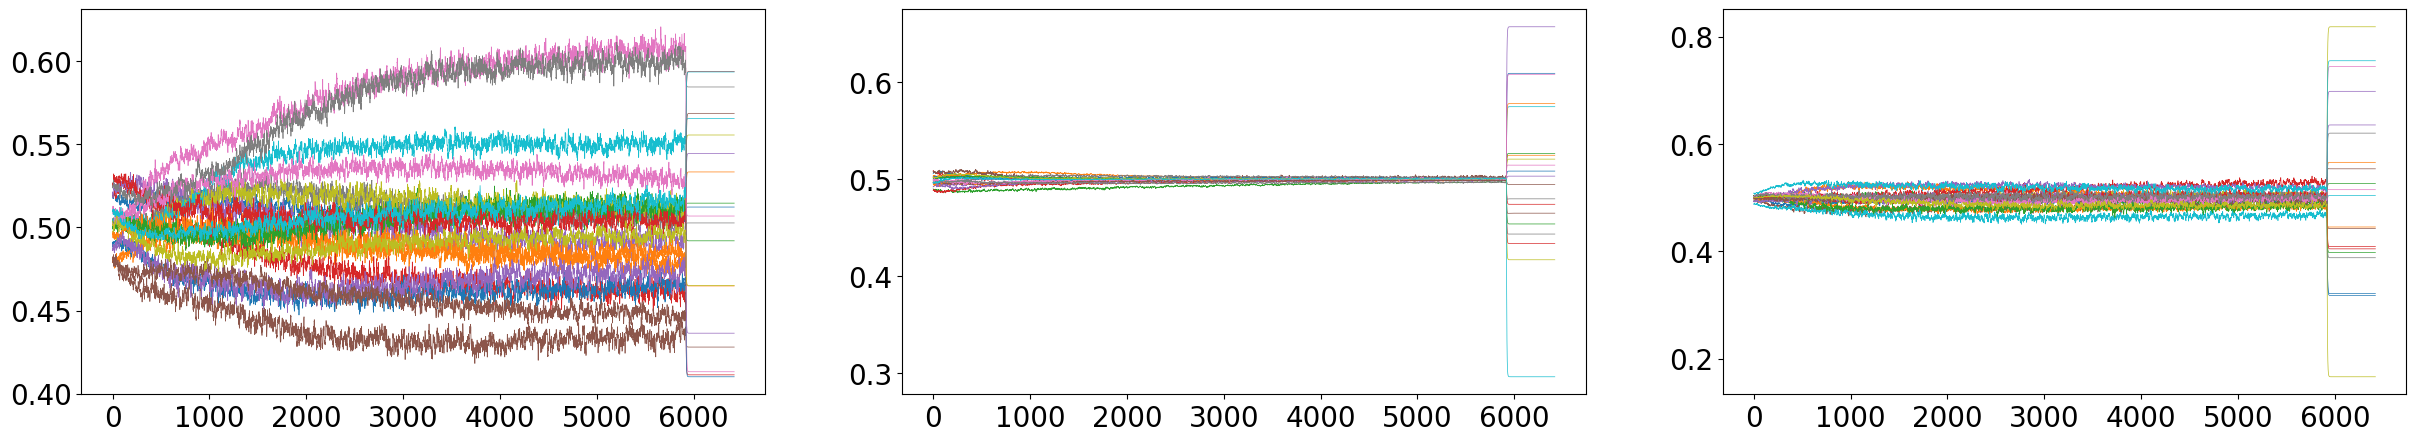

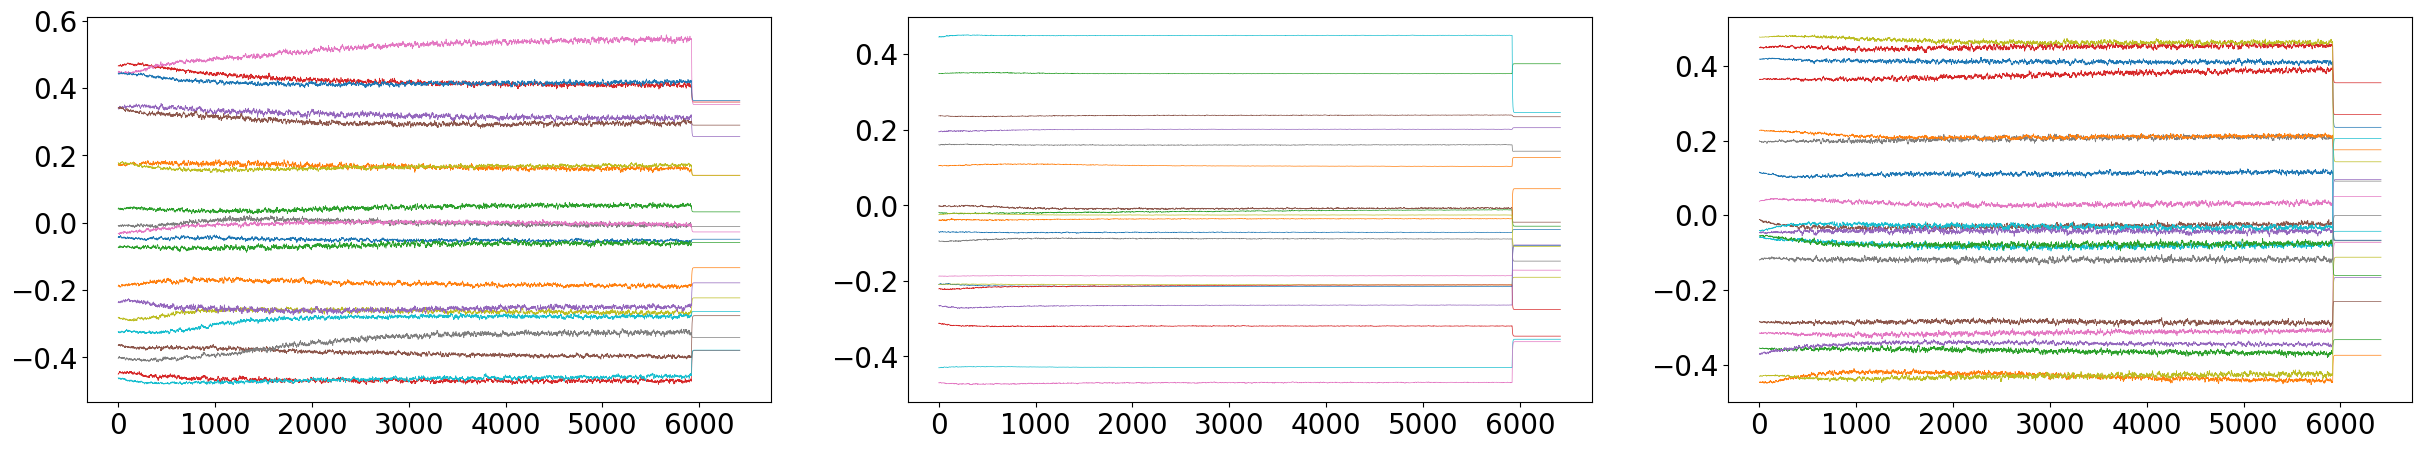

In [363]:
onset_time = 100
nl = mlp_parameters['layers_number']
fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(model.y_mean_s[i], axis=0)
    ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    delta_mean_i = np.stack(model.delta_mean_s[i], axis=0)
    ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

In [369]:
stimuli_presentation = list(range(10))

for stimuli_name in tqdm.tqdm_notebook(stimuli_presentation):
        
        with torch.no_grad():
                # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
            
            for inpt in inpt_test[target_test==stimuli_name][:max_stimuli_repeat]:
            
                layers, output = model(inpt.unsqueeze(0))
                        
# target_pred = output.argmax(0)
# metric = metric_function(target_test, target_pred)

/tmp/ipykernel_1221793/4042183549.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for stimuli_name in tqdm.tqdm_notebook(stimuli_presentation):


  0%|          | 0/10 [00:00<?, ?it/s]

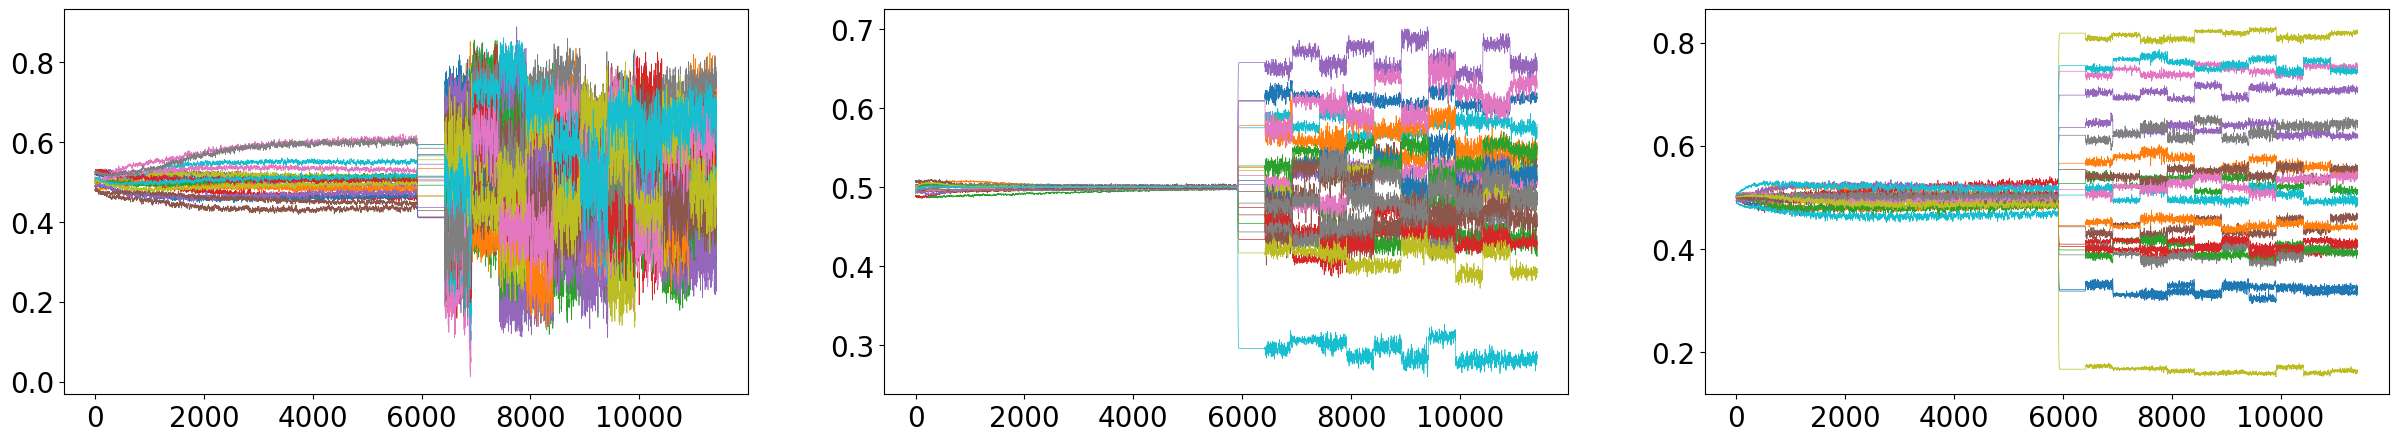

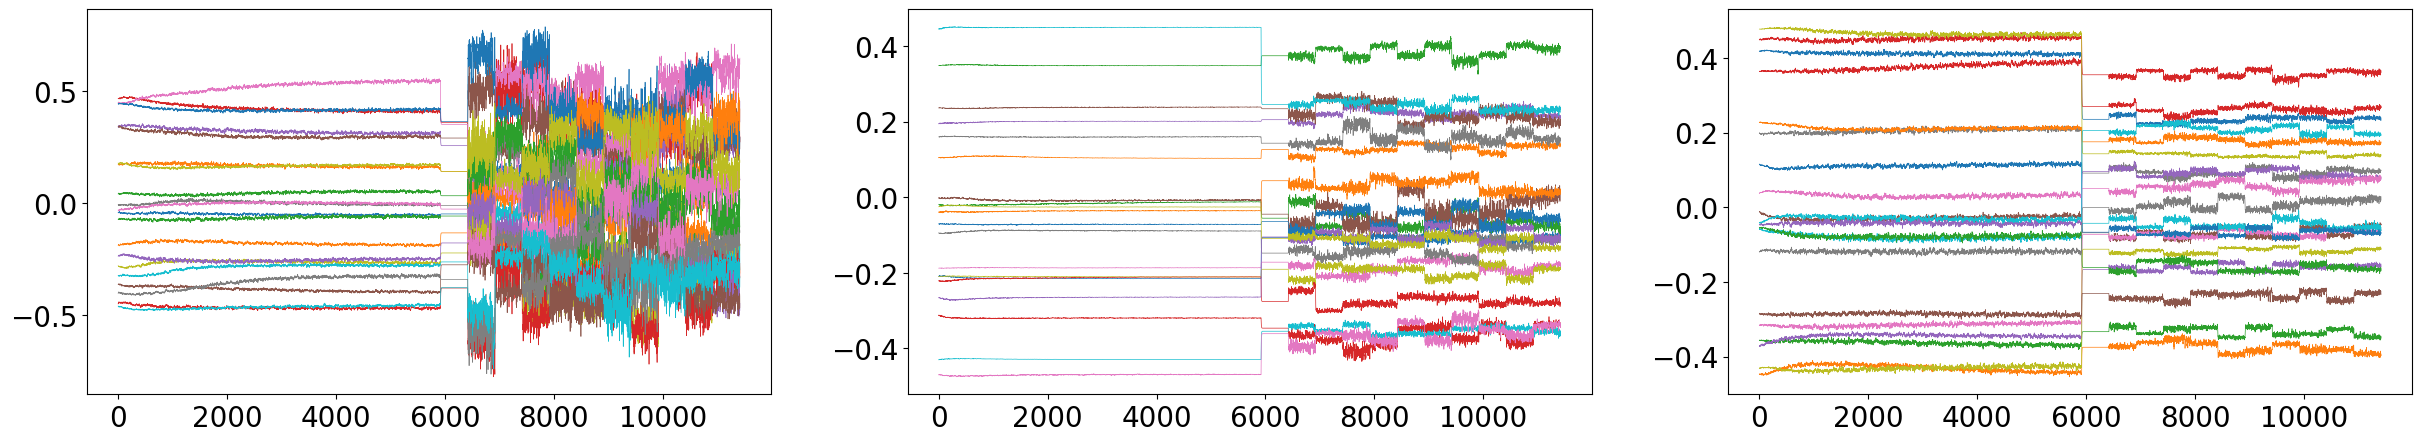

In [370]:
onset_time = 100
nl = mlp_parameters['layers_number']
fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(model.y_mean_s[i], axis=0)
    ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    delta_mean_i = np.stack(model.delta_mean_s[i], axis=0)
    ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
plt.show()

In [350]:
inpt_test[target_test==1].shape

torch.Size([1135, 784])

In [338]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

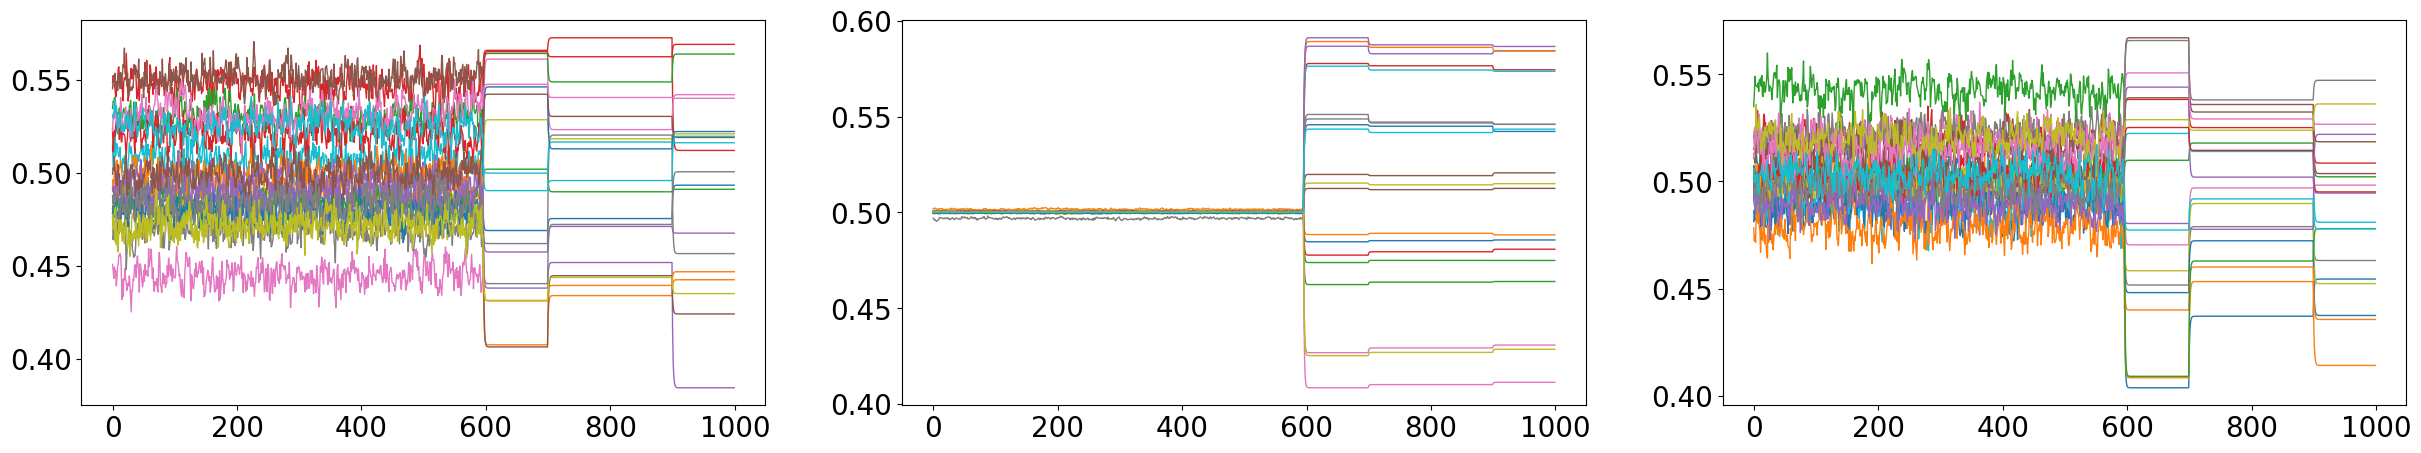

In [331]:
nl = mlp_parameters['layers_number']
fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(model.y_mean_s[i], axis=0)
    ax.plot(y_mean_i[-1000:,:], linewidth=1)
plt.show()

In [227]:
layers[0][-1].T

tensor([[5.6729e-09, 1.1195e-06, 4.4790e-03,  ..., 9.9995e-01, 2.8235e-05,
         9.9999e-01],
        [4.2471e-07, 2.5841e-05, 3.3534e-02,  ..., 1.0000e+00, 1.2522e-03,
         9.9960e-01],
        [1.3506e-09, 2.2707e-05, 1.4839e-03,  ..., 9.9999e-01, 1.7782e-04,
         9.9992e-01],
        ...,
        [1.7125e-07, 2.9040e-06, 8.1312e-03,  ..., 9.9994e-01, 1.0626e-03,
         1.0000e+00],
        [2.5595e-04, 3.7872e-01, 1.3386e-03,  ..., 9.9986e-01, 2.4763e-04,
         9.9998e-01],
        [2.9896e-07, 1.4156e-05, 1.4435e-04,  ..., 1.0000e+00, 1.6677e-01,
         9.9998e-01]], device='cuda:0')

In [228]:
metric

0.1066

In [171]:
inpt_test.shape

torch.Size([10000, 784])

In [172]:
target_test

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [540]:
# xrange = np.linspace(-0.1,0.1,10)
# plt.plot(xrange, sigmoid(xrange))
# plt.plot(xrange, 0.25*xrange+0.5)

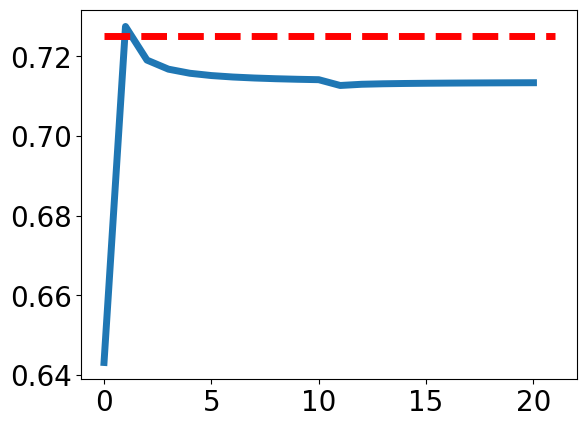

In [724]:
def sigmoid(x):
    
    return 1./(1. + np.exp(-x))

y_H = 0.7
lmbd = 1e-3
I = np.random.rand(1).item()
y_inf = (I + y_H + 2)/5. # converge to homeostasis is y_H = 0.5!

average_activity = list(np.random.rand(1)) #list(np.random.rand(1))

for i in range(20):
    
#     activity = sigmoid(y_H - average_activity[-1])

    activity = sigmoid(I + y_H - np.mean(average_activity[-10:]))

#     activity = average_activity[-1] + lmbd*(sigmoid(y_H - average_activity[-1]) - average_activity[-1])  
    average_activity.append(activity)
    
plt.plot(average_activity)
plt.hlines(y_inf, 0, len(average_activity), linestyle='--', color='red')

In [718]:
# y_inf - y_H

In [714]:
# sigmoid(y_H - y_inf) - y_inf

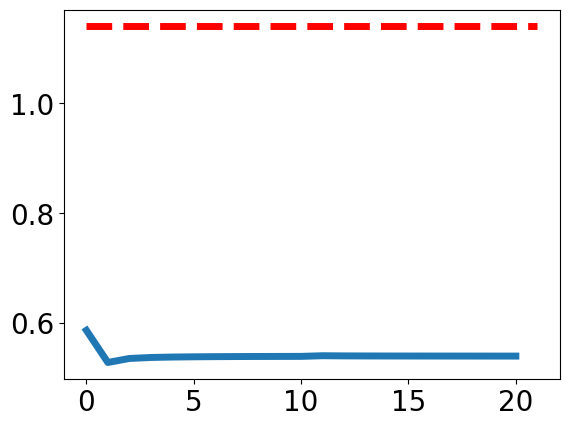

In [468]:
[1,2][-10:]

[1, 2]

In [28]:
# def evaluate_corruption(model, exc_ratio, p_corruption):
        
#     setattr(model, 'exc_ratio', exc_ratio)
#     setattr(model, 'p_corruption', p_corruption)

#     with torch.no_grad():
#         # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
#         layers_activations, output = model(inpt_test) 
#         H = layers_activations[-1][-1].T
#         target_pred = output.argmax(0)
#         acc = accuracy_score(to_numpy(target_test), to_numpy(target_pred))

#     _, output = make_ls_solution(H, target_test, bias=True)
#     target_pred = output.argmax(1)
#     acc_ls = accuracy_score(to_numpy(target_test), to_numpy(target_pred))

#     return [acc, acc_ls]

In [27]:
# setattr(model, 'corruption', True)
# import warnings
# warnings.filterwarnings('ignore')

# p_corruption_space = np.linspace(0,0.5,num=100)
# exc_ratio_space = np.linspace(1e-5,0.9,num=100)

# acc_grid = np.empty((exc_ratio_space.shape[0], 
#                      p_corruption_space.shape[0]))

# acc_ls_grid = np.empty((exc_ratio_space.shape[0], 
#                         p_corruption_space.shape[0]))

# ER_S, PC_S = np.meshgrid(exc_ratio_space, p_corruption_space)
# ER_PC_S = np.stack([ER_S, PC_S], axis=-1).reshape(-1,2)

# acc_res = Parallel(n_jobs=int(N_CPU*0.8))(delayed(evaluate_corruption)(model, 
#                                                                        exc_ratio, 
#                                                                        p_corr) for\
#                                           (exc_ratio, p_corr) in tqdm.tqdm_notebook(ER_PC_S))

        